In [3]:
import math
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import Dense, LSTM

from tensorflow.keras.layers import StringLookup

#ignore warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
#改配色方案
# brewer2mpl.get_map args: set name set type number of colors
import matplotlib as mpl

#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['font.family'] = 'Times New Roman'

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

In [5]:
data=pd.read_csv('data.csv')
item=3

data['time']=pd.to_datetime(data['time'],format = '%Y-%m-%d %H:%M:%S')

turbulence = np.zeros((len(data), 1))

speed_for_turbulence = np.array(data['speed(m/s)_%s'%item])

for i in range(5,len(data)-1):
  tmp = speed_for_turbulence[(i-5):(i+1)]
  turbulence[i][0] = np.std(tmp)/(np.mean(tmp)+0.001)

turbulence[turbulence>1] = 1
data['turbulence_%s'%item]=turbulence

angle=np.array(data['angle(°)_%s'%item])
cos_angle=[np.cos(np.pi*(i/180)) for i in angle]
data['angle(°)_%s'%item]=cos_angle

norm_data_original=data[data['state_%s'%item]==10]
norm_data1=norm_data_original[norm_data_original['active_value_%s'%item]==100]
norm_data2=norm_data_original[norm_data_original['active_value_%s'%item]==0]

norm_data=pd.concat([norm_data1,norm_data2])

ab_data=data[data['state_%s'%item]!=10]
limit_data=pd.concat([norm_data_original,norm_data],axis =0).drop_duplicates(keep=False)
limit_data=pd.concat([limit_data,ab_data])

speed_all=np.array(data['speed(m/s)_%s'%item])
power_all=np.array(data['power(kW)_%s'%item])
temperature_all=np.array(data['temperature(℃)_%s'%item])
angle_all=np.array(data['angle(°)_%s'%item])
turbulence_all=np.array(data['turbulence_%s'%item])


speed=np.array(norm_data['speed(m/s)_%s'%item])
power=np.array(norm_data['power(kW)_%s'%item])
temperature=np.array(norm_data['temperature(℃)_%s'%item])
angle=np.array(norm_data['angle(°)_%s'%item])
turbulence=np.array(norm_data['turbulence_%s'%item])

speed_index=norm_data['speed(m/s)_%s'%item].index 

#generate dataset
speed_data=[[] for i in range(120)]
power_data=[[] for i in range(120)]
tem_data=[[] for i in range(120)]
angle_data=[[] for i in range(120)]
turbulence_data=[[] for i in range(120)]

speed_index=norm_data['speed(m/s)_%s'%item].index
for i in speed_index:
    for j in range(120):
        speed_data[j].append(speed_all[i-j])

power_index=norm_data['power(kW)_%s'%item].index

for i in power_index:
    for j in range(120):
        power_data[j].append(power_all[i-j])
    
tem_index=norm_data['temperature(℃)_%s'%item].index

for i in tem_index:
    for j in range(120):
        tem_data[j].append(temperature_all[i-j])

angle_index=norm_data['angle(°)_%s'%item].index

for i in angle_index:
    for j in range(120):
        angle_data[j].append(angle_all[i-j])

turbulence_index=norm_data['turbulence_%s'%item].index

for i in turbulence_index:
    for j in range(120):
        turbulence_data[j].append(turbulence_all[i-j])
        
df=pd.DataFrame()
for j in range(120):
    df['speed_%s'%j]=speed_data[j]
    
df_power=pd.DataFrame()
for j in range(120):
    df_power['power_%s'%j]=power_data[j]

df_tem=pd.DataFrame()
for j in range(120):
    df_tem['tem_%s'%j]=tem_data[j]

df_angle=pd.DataFrame()
for j in range(120):
    df_angle['angle_%s'%j]=angle_data[j]

df_turbulence=pd.DataFrame()
for j in range(120):
    df_turbulence['turbulence_%s'%j]=turbulence_data[j]

speed_df=pd.DataFrame()
speed_df['speed0']=df['speed_0']
speed_df['power1']=df_power['power_1']
speed_df['tem_0']=df_tem['tem_0']
speed_df['angle_0']=df_angle['angle_0']
speed_df['turbulence_0']=df_turbulence['turbulence_0']

speed_df['speed1']=df['speed_1']
speed_df['power2']=df_power['power_2']
speed_df['tem_1']=df_tem['tem_1']
speed_df['angle_1']=df_angle['angle_1']
speed_df['turbulence_1']=df_turbulence['turbulence_1']

speed_df['speed2']=df['speed_2']
speed_df['power3']=df_power['power_3']
speed_df['tem_2']=df_tem['tem_2']
speed_df['angle_2']=df_angle['angle_2']
speed_df['turbulence_2']=df_turbulence['turbulence_2']

speed_df['speed3']=df['speed_3']
speed_df['power4']=df_power['power_4']
speed_df['tem_3']=df_tem['tem_3']
speed_df['angle_3']=df_angle['angle_3']
speed_df['turbulence_3']=df_turbulence['turbulence_3']

speed_df['turbulence_4']=df_turbulence['turbulence_4']

'\n#进行u-sd标准化\ncol_name=speed_df.columns\nfor item in col_name:\n    tmp=np.array(speed_df[item])\n    tmp_1=(tmp-np.mean(tmp))/np.std(tmp)\n    speed_df[item]=tmp_1\n\npower=(power-np.min(power))/(np.max(power)-np.min(power))\n'

In [6]:
speed_df_offline=speed_df
power_offline=power
data_offline=data
norm_data_offline=norm_data

In [7]:
total_speed=np.arange(5,13,0.1)

speed=np.array(data_offline['speed(m/s)_%s'%item])
power=np.array(data_offline['power(kW)_%s'%item])
power=(power-np.min(power))/(np.max(power)-np.min(power))
power_list=[]

for tmp_speed in total_speed:
    
    speed_index=norm_data_offline[(norm_data_offline['speed(m/s)_%s'%item]>=tmp_speed)&(norm_data_offline['speed(m/s)_%s'%item]<=tmp_speed+0.1)].index
    speed_index_pre=[]
    for i in speed_index:
        speed_index_pre.append(i-24)

    speed_10=speed[speed_index]
    power_10=power[speed_index]
    
    power_list.append(power_10)

In [ ]:
!pip install fitter

In [ ]:
from fitter import Fitter

for i in range(len(power_list)):
    fig, axes = plt.subplots(figsize=(5, 3), dpi=300)
    f = Fitter(power_list[i],distributions=['beta','gamma','laplace','norm','weibull_min','uniform'])  # 创建Fitter类
    f.fit()  # fit function
    f.plot_pdf(Nbest=5, lw=2, method='sumsquare_error')
    plt.title('Speed Range: [%s,%s]'%(round(total_speed[i],2),round(total_speed[i]+0.1,2)))
    print(f.summary())  # output fitting result
    print(total_speed[i])

### Skewness and kurtosis analysis

In [ ]:
total_speed = np.arange(5,13,0.1)

speed = np.array(data_offline['speed(m/s)_%s'%item])
power = np.array(data_offline['power(kW)_%s'%item])
power = (power-np.min(power))/(np.max(power)-np.min(power))
power_list = []

for tmp_speed in total_speed:
    speed_index = norm_data_offline[(norm_data_offline['speed(m/s)_%s'%item]>=tmp_speed)&(norm_data_offline['speed(m/s)_%s'%item]<=tmp_speed+0.1)].index
    speed_index_pre = []
    for i in speed_index:
        speed_index_pre.append(i-24)

    speed_10=speed[speed_index]
    power_10=power[speed_index]
    
    power_list.append(power_10)

In [ ]:
np.shape(power_list)

(80,)

In [ ]:
from scipy import stats

skew_list = []
kurt_list = []
for i in range(len(power_list)):
  skew_list.append(stats.skew(power_list[i]))
  kurt_list.append(stats.kurtosis(power_list[i]))

In [ ]:
for i in range(len(kurt_list)):
  if kurt_list[i] > 10:
    kurt_list[i] = 10

In [ ]:
total_speed=np.arange(5,13,0.1)

result_df = pd.DataFrame()
for i in range(len(total_speed)):
  total_speed[i] = round(total_speed[i],1)
result_df['speed'] = total_speed
result_df['skew'] = skew_list
result_df['kurt'] = kurt_list

Text(0, 0.5, 'Skewness')

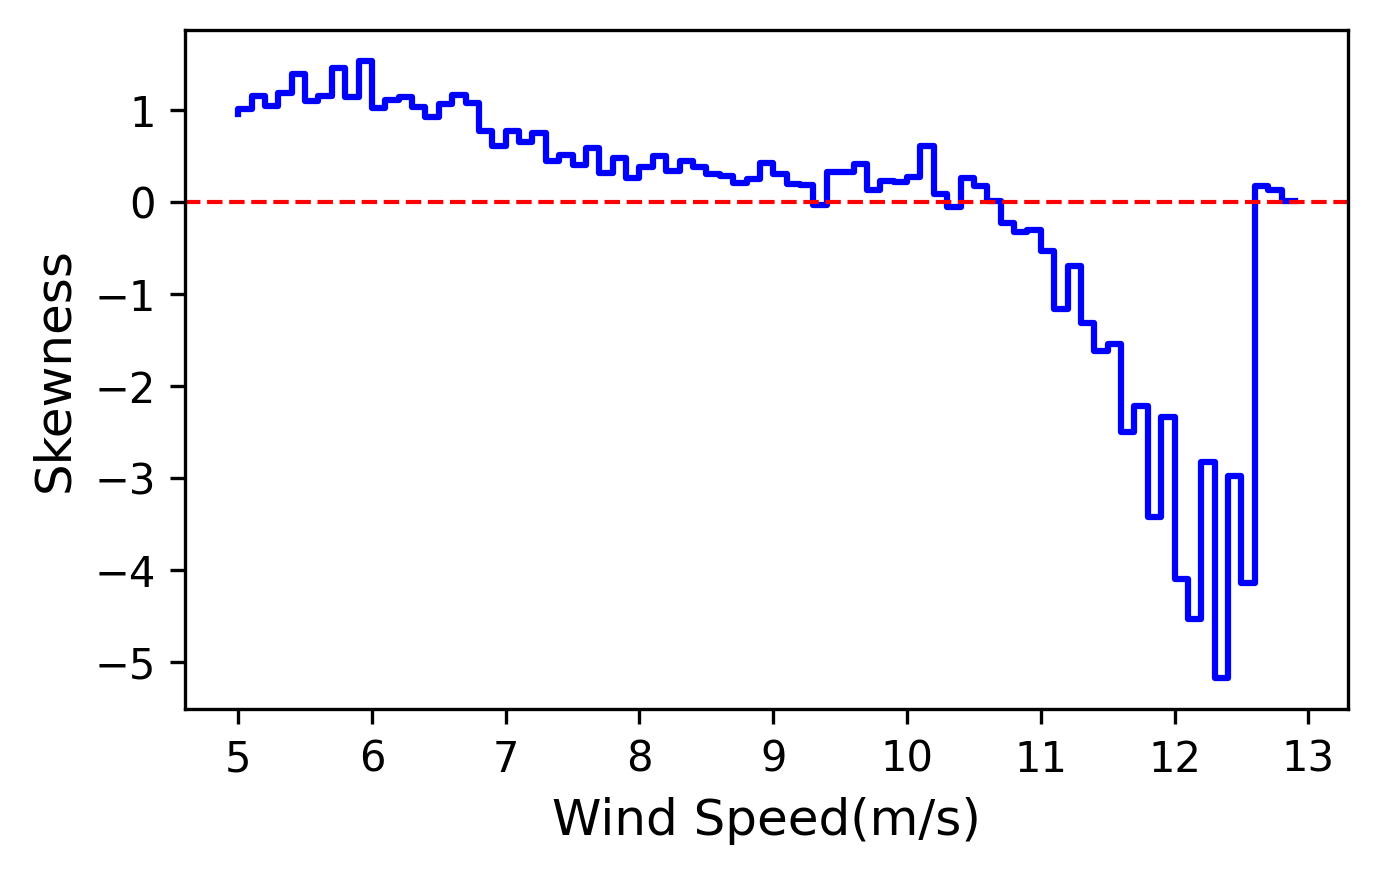

In [ ]:
fig, axes = plt.subplots(figsize=(5, 3), dpi=300)

plt.step(result_df['speed'], result_df['skew'], color='blue')
axes.axhline(0, color='red', linewidth=1,  linestyle='--')
axes.set_xlabel('Wind Speed(m/s)',fontsize=12)
axes.set_ylabel('Skewness',fontsize=12)

Text(0, 0.5, 'Kurtosis')

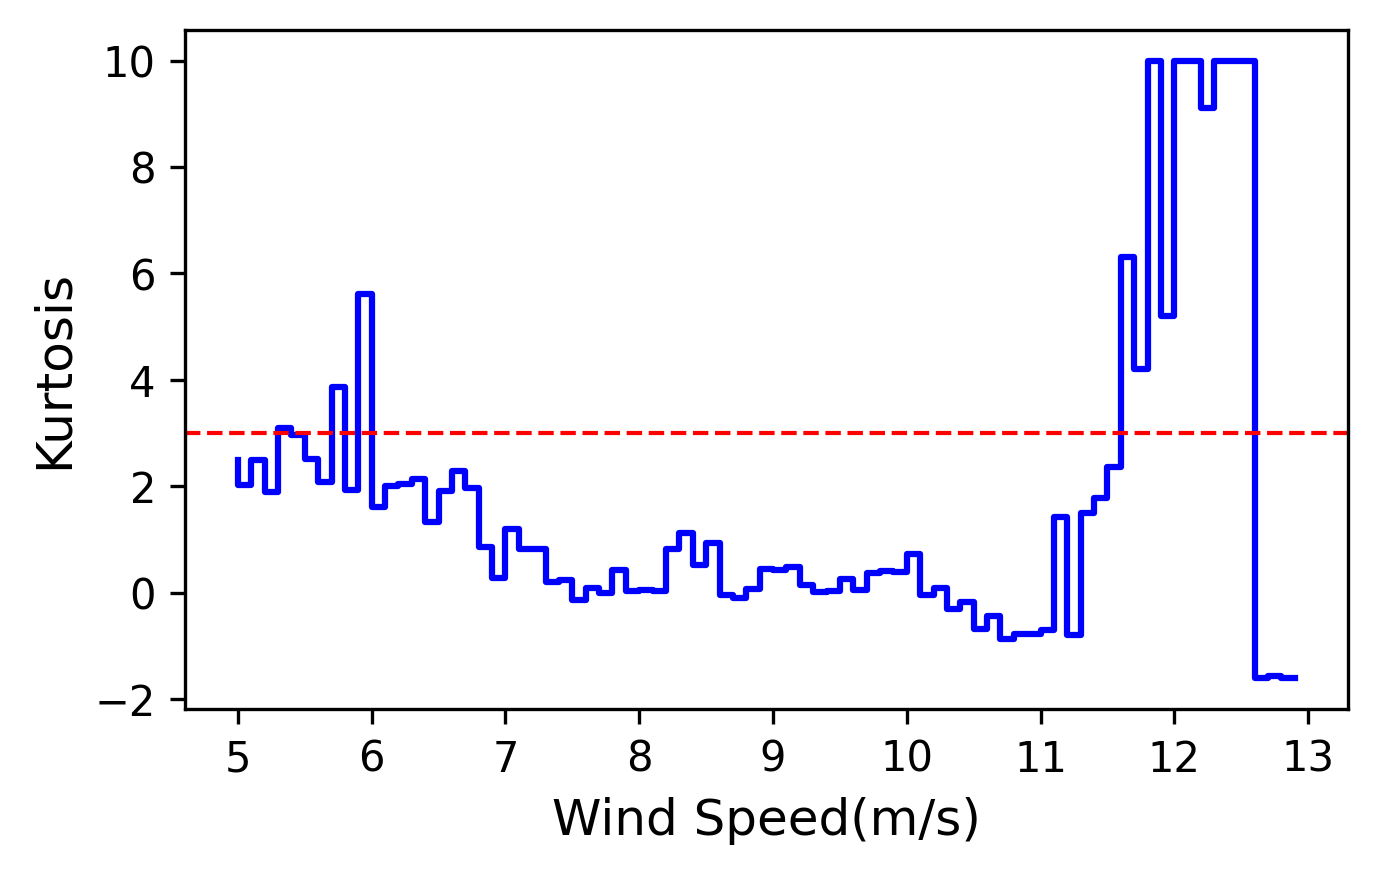

In [ ]:
fig, axes = plt.subplots(figsize=(5, 3), dpi=300)

plt.step(result_df['speed'], result_df['kurt'], color='blue')
axes.axhline(3, color='red', linewidth=1,  linestyle='--')
axes.set_xlabel('Wind Speed(m/s)',fontsize=12)
axes.set_ylabel('Kurtosis',fontsize=12)